# Understanding Customer attrition through Survival Analysis (Kaplan Meier & Cox Regression on) 

Survival analysis is a statistical technique used to analyze the time until the occurrence of an event of interest. It is commonly applied in medical research to study patient survival times but has found applications in various fields, including business analytics, where it is used to understand customer churn, also known as customer survival analysis. Two primary methods within survival analysis are Kaplan-Meier estimation and Cox proportional hazards regression, both of which are frequently employed in studying customer churn

In this project we will be making use of microsoft's adventureworks 2022 database (https://learn.microsoft.com/en-us/sql/samples/adventureworks-install-configure?view=sql-server-ver16) to predict how long it takes for customers to churn and what exactly is responsible for this churn. We will also be making use of an imaginary company which sells primarily 3 types of products namely accessories, bikes and clothes. Let's Begin!

# Imports

In [2]:
import pandas as pd
import numpy as np
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score,accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.pipeline import FeatureUnion, make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter 
import warnings
warnings.filterwarnings('ignore')

In [2]:
#SQL Imports
#This chunk of code below queries in the CustomerID, ProductID, Product Category, Product subcategory and SalesOrderID 
#all of this is information relating to the products sold by the company

conn = pyodbc.connect('DRIVER={SQL Server};'
                      'SERVER=LAPTOP-TFH5SEUP;'
                      'DATABASE=AdventureWorks2022;'
                     'Trusted_Connection=yes;')

sql_for_df1 = """SELECT
SC.[CustomerID],
PP.ProductID,
PC.[Name] AS [Product Category],
PS.[Name] AS [Product Subcategory],
SH.[SalesOrderID]
FROM [Sales].[SalesOrderHeader] SH
LEFT JOIN [Sales].[Customer] SC ON SH.CustomerID = SC.[CustomerID]
LEFT JOIN [Sales].[SalesOrderDetail] SS ON SS.SalesOrderID = SH.SalesOrderID
LEFT JOIN [Production].[Product] PP ON PP.ProductID = SS.ProductID
LEFT JOIN [Production].[ProductSubcategory] PS ON PS.[ProductSubcategoryID] = PP.ProductSubcategoryID
LEFT JOIN [Production].[ProductCategory] PC ON PC. [ProductCategoryID] = PS.ProductCategoryID
"""

category = pd.read_sql(sql_for_df1, conn)

conn.close()

In [3]:
category.head()

,CustomerID,ProductID,Product Category,Product Subcategory,SalesOrderID
0,29580,707,Accessories,Helmets,43665
1,29614,707,Accessories,Helmets,43668
2,29844,707,Accessories,Helmets,43673
3,29824,707,Accessories,Helmets,43677
4,29889,707,Accessories,Helmets,43678


In [4]:
#This chunk of code below queries in the CustomerID, orderDate, ShipDate Unit Price, Total Due, Line Total, region 
#all of this is information relating to the company's product sales

conn = pyodbc.connect('DRIVER={SQL Server};'
                      'SERVER=LAPTOP-TFH5SEUP;'
                      'DATABASE=AdventureWorks2022;'
                     'Trusted_Connection=yes;')

sql_for_df1 = """select soh.customerID,soh.OrderDate,soh.ShipDate,sod.UnitPrice, soh.TotalDue, sod.LineTotal
, st.Name as region  from
Sales.SalesOrderDetail as sod
join Sales.SalesOrderHeader as soh 
on sod.SalesOrderID=soh.SalesOrderID
join Production.Product as p
on sod.ProductID=p.ProductID
INNER JOIN Sales.SalesTerritory AS St
    ON Soh.[TerritoryID] = St.[TerritoryID]
"""

sales = pd.read_sql(sql_for_df1, conn)

conn.close()

In [5]:
sales.head()

,customerID,OrderDate,ShipDate,UnitPrice,TotalDue,LineTotal,region
0,29825,2011-05-31,2011-06-07,2024.994,23153.2339,2024.994,Southeast
1,29825,2011-05-31,2011-06-07,2024.994,23153.2339,6074.982,Southeast
2,29825,2011-05-31,2011-06-07,2024.994,23153.2339,2024.994,Southeast
3,29825,2011-05-31,2011-06-07,2039.994,23153.2339,2039.994,Southeast
4,29825,2011-05-31,2011-06-07,2039.994,23153.2339,2039.994,Southeast


In [6]:
# This chunk of code below queries in the BirthDate, MaritalStatus Gender, Number of children at home, postal code, 
# total children, education , occupation, house owner, customer key, no of cars owned, Yearly income 
# all of this is information relating customer's personal information

conn = pyodbc.connect('DRIVER={SQL Server};'
                      'SERVER=LAPTOP-TFH5SEUP;'
                      'DATABASE=AdventureWorksDW2022;'
                     'Trusted_Connection=yes;')

sql_for_df1 = """SELECT  [BirthDate],
[MaritalStatus],
[YearlyIncome],
[Gender],[NumberChildrenAtHome], dg.PostalCode, 
dc.[TotalChildren],
[EnglishEducation],[EnglishOccupation],
[HouseOwnerFlag],[CustomerKey],
[NumberCarsOwned] 
FROM [dbo].[DimCustomer] as dc
Join [dbo].[DimGeography] as dg
on dc.[GeographyKey] = dg.GeographyKey
"""

data = pd.read_sql(sql_for_df1, conn)

conn.close()

In [7]:
data.head()

,BirthDate,MaritalStatus,YearlyIncome,Gender,NumberChildrenAtHome,PostalCode,TotalChildren,EnglishEducation,EnglishOccupation,HouseOwnerFlag,CustomerKey,NumberCarsOwned
0,1971-10-06,M,90000.0,M,0,4700,2,Bachelors,Professional,1,11000,0
1,1976-05-10,S,60000.0,M,3,3198,3,Bachelors,Professional,0,11001,1
2,1971-02-09,M,60000.0,M,3,7001,3,Bachelors,Professional,1,11002,1
3,1973-08-14,S,70000.0,F,0,2113,0,Bachelors,Professional,0,11003,1
4,1979-08-05,S,80000.0,F,5,2500,5,Bachelors,Professional,1,11004,4


# Section 1: Data Modeling

In [8]:
#We begin by renaming the customer ID columns in the dataframes called category and data. These two columns have the same 
#information but different column names which would pose an issue when we try to merge these columns

category.rename(columns={'CustomerID':'customerID'},inplace=True)
data.rename(columns={'CustomerKey' : 'customerID'},inplace=True)

In [9]:
#Next we merge the tables we imported from sql. Note: we merged them seperately, first in a variable named
#dt and then in a variable named df. This is because you can't merge more than 2 dataframes at once in python

dt = pd.merge(sales,data,how='inner',on='customerID')
df = pd.merge(category,dt,how='inner',on='customerID')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324320 entries, 0 to 324319
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   customerID            324320 non-null  int64         
 1   ProductID             324320 non-null  int64         
 2   Product Category      324320 non-null  object        
 3   Product Subcategory   324320 non-null  object        
 4   SalesOrderID          324320 non-null  int64         
 5   OrderDate             324320 non-null  datetime64[ns]
 6   ShipDate              324320 non-null  datetime64[ns]
 7   UnitPrice             324320 non-null  float64       
 8   TotalDue              324320 non-null  float64       
 9   LineTotal             324320 non-null  float64       
 10  region                324320 non-null  object        
 11  BirthDate             324320 non-null  object        
 12  MaritalStatus         324320 non-null  object        
 13 

In [13]:
#Next we rename some columns for more clarity

df.rename(columns={'EnglishEducation':'Education','EnglishOccupation':'Occupation'},inplace=True)

In [14]:
#Here we use the customer's birthdate and orderdate to calculate their Age at the time of purchase
df['BirthDate']= df['BirthDate'].astype('datetime64[ns]')
df['Age']= df['OrderDate'].dt.year-df['BirthDate'].dt.year

In [15]:
#Now we begin to encode the categorical variables notice how we use nominal encoding for some columns
#without any inherent order and ordinal encoding for those with an obvious inherent order like occupation or profession

df['MaritalStatus']=pd.get_dummies(df['MaritalStatus'],drop_first=True,dtype='int')

df['Gender']=pd.get_dummies(df['Gender'],drop_first=True,dtype='int')

df['Education']=df['Education'].replace({'Bachelors':4, 'Partial College':3, 'High School':2,
       'Partial High School':1, 'Graduate Degree':5, 'None':0})

df['Occupation']=df['Occupation'].replace({'Professional':5, 'Management':4, 'Skilled Manual':3, 'Clerical':2,
       'Manual':1, 'None':0})

df['HouseOwnerFlag']=df['HouseOwnerFlag'].astype('int')

In [16]:
#Finally, we drop the region columns as it will be of no use
df = df.drop('region',axis=1)

# Section 2: Preparing the Kaplan-Meier Curve
​
The Kaplan-Meier Curve represents a simple non-parametric visualization of survival likelihood function in our data. In that sense, it can be thought of as part of the EDA process for survival analysis. Let's start by fitting a simple Kaplan-Meier Curve on our data.

In [17]:
# we begin by saving our sales dataframe (because it is the dataframe containing the order date)
# in a variable called data with columns 'order_date', 'delivery_date', and 'customer_id'
data = pd.DataFrame(sales)

# Convert date columns to datetime objects
data['OrderDate'] = pd.to_datetime(data['OrderDate'])
data['ShipDate'] = pd.to_datetime(data['ShipDate'])

# Sort DataFrame by order_date
data.sort_values(by='OrderDate', inplace=True)

# Group by customer_id and get the first and last interaction dates
result = data.groupby('customerID').agg({'OrderDate': 'first', 'ShipDate': 'last'}).reset_index()

print(result)

       customerID  OrderDate   ShipDate
0           11000 2011-06-21 2013-10-10
1           11001 2011-06-17 2014-05-19
2           11002 2011-06-09 2013-08-02
3           11003 2011-05-31 2013-10-17
4           11004 2011-06-25 2013-10-08
...           ...        ...        ...
19114       30114 2012-05-30 2014-03-08
19115       30115 2012-06-30 2014-04-07
19116       30116 2013-05-30 2014-03-08
19117       30117 2011-07-01 2014-04-07
19118       30118 2012-07-31 2014-05-08

[19119 rows x 3 columns]


In [18]:
result.head()

,customerID,OrderDate,ShipDate
0,11000,2011-06-21,2013-10-10
1,11001,2011-06-17,2014-05-19
2,11002,2011-06-09,2013-08-02
3,11003,2011-05-31,2013-10-17
4,11004,2011-06-25,2013-10-08


In [19]:
# We then merge this with the product category data frame
result =pd.merge(result,category[['customerID','Product Category']],on='customerID',how='inner')
result.head()

,customerID,OrderDate,ShipDate,Product Category
0,11000,2011-06-21,2013-10-10,Accessories
1,11000,2011-06-21,2013-10-10,Bikes
2,11000,2011-06-21,2013-10-10,Bikes
3,11000,2011-06-21,2013-10-10,Accessories
4,11000,2011-06-21,2013-10-10,Clothing


In [20]:
survivor_analysis = pd.DataFrame(result)

In [21]:
# Now to calculate the actual amount of time spent transacting with us
survivor_analysis['months_between'] = (survivor_analysis['ShipDate'] - survivor_analysis['OrderDate']).dt.days // 30

In [22]:
survivor_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customerID        121317 non-null  int64         
 1   OrderDate         121317 non-null  datetime64[ns]
 2   ShipDate          121317 non-null  datetime64[ns]
 3   Product Category  121317 non-null  object        
 4   months_between    121317 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 4.6+ MB


In [23]:
survivor_analysis.head()

,customerID,OrderDate,ShipDate,Product Category,months_between
0,11000,2011-06-21,2013-10-10,Accessories,28
1,11000,2011-06-21,2013-10-10,Bikes,28
2,11000,2011-06-21,2013-10-10,Bikes,28
3,11000,2011-06-21,2013-10-10,Accessories,28
4,11000,2011-06-21,2013-10-10,Clothing,28


In [24]:
#checking the maximum ship date (for future use)
survivor_analysis['ShipDate'].max()

Timestamp('2014-07-07 00:00:00')

The date above will then serve as the current date of our survival analysis because we assume that this is an ongoing business. It will also serve as a threshold to calculate customer churn. For this project we will be using anything above 6 months as churned. Simply put this means that any transaction which is more than 6 months before our final transaction/current date of 2014/07/07 will be regarded as churned.

In [25]:
#Calculating Customer churn
last_interaction_dates = survivor_analysis.groupby('customerID')['ShipDate'].last().reset_index()

# Set the current date as '2014-07-07'
current_date = pd.to_datetime('2014-07-07')

# Calculate the difference in months between the last interaction date and the current date
last_interaction_dates['months_since_last_interaction'] = (current_date - last_interaction_dates['ShipDate']).dt.days // 30

# Create a new column indicating if the last interaction was more than 6 months ago
last_interaction_dates['Customer_Churn'] = (last_interaction_dates['months_since_last_interaction'] > 6).astype(int)

# Print the result
print(last_interaction_dates[['customerID', 'Customer_Churn']])

       customerID  Customer_Churn
0           11000               1
1           11001               0
2           11002               1
3           11003               1
4           11004               1
...           ...             ...
19114       30114               0
19115       30115               0
19116       30116               0
19117       30117               0
19118       30118               0

[19119 rows x 2 columns]


In [26]:
#This is the final step in the data modelling where we merge all necessary
#data frames and columns
data=pd.merge(survivor_analysis,last_interaction_dates[['customerID','Customer_Churn']],on='customerID',how='inner')
data = pd.merge(data,df[['customerID','MaritalStatus','Gender','Age','Gender','YearlyIncome']],on='customerID',how='inner')

In [28]:
data.head()

,customerID,OrderDate,ShipDate,Product Category,months_between,Customer_Churn,MaritalStatus,Gender,Age,Gender,YearlyIncome
0,11000,2011-06-21,2013-10-10,Accessories,28,1,0,1,40,1,90000.0
1,11000,2011-06-21,2013-10-10,Accessories,28,1,0,1,42,1,90000.0
2,11000,2011-06-21,2013-10-10,Accessories,28,1,0,1,42,1,90000.0
3,11000,2011-06-21,2013-10-10,Accessories,28,1,0,1,42,1,90000.0
4,11000,2011-06-21,2013-10-10,Accessories,28,1,0,1,42,1,90000.0


In [29]:
# Setup
from lifelines import KaplanMeierFitter, CoxPHFitter 

In [66]:
data[data['Customer_Churn']==data['Customer_Churn'].isna()]

,customerID,OrderDate,ShipDate,Product Category,months_between,Customer_Churn,MaritalStatus,Gender,Age,Gender,YearlyIncome
512,11001,2011-06-17,2014-05-19,Accessories,35,0,1,1,35,1,60000.0
513,11001,2011-06-17,2014-05-19,Accessories,35,0,1,1,37,1,60000.0
514,11001,2011-06-17,2014-05-19,Accessories,35,0,1,1,37,1,60000.0
515,11001,2011-06-17,2014-05-19,Accessories,35,0,1,1,37,1,60000.0
516,11001,2011-06-17,2014-05-19,Accessories,35,0,1,1,37,1,60000.0
...,...,...,...,...,...,...,...,...,...,...,...
5247510,29480,2013-12-17,2013-12-24,Bikes,0,0,1,0,36,0,30000.0
5247511,29480,2013-12-17,2013-12-24,Bikes,0,0,1,0,36,0,30000.0
5247512,29480,2013-12-17,2013-12-24,Bikes,0,0,1,0,36,0,30000.0
5247513,29480,2013-12-17,2013-12-24,Bikes,0,0,1,0,36,0,30000.0


# Kaplan Meier Plot

Text(0, 0.5, 'Survival probability')

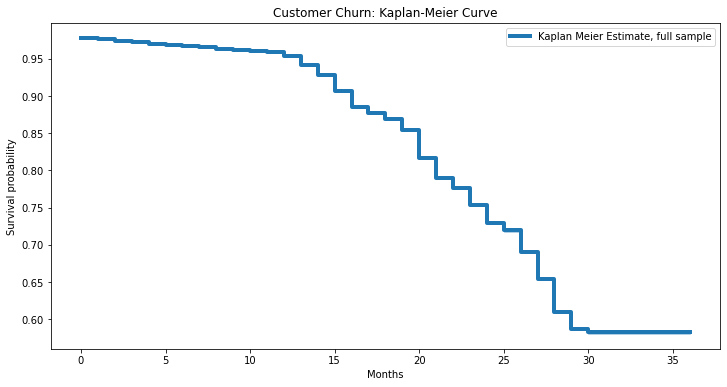

In [67]:
#Kaplan meier plot
kmf = KaplanMeierFitter()

kmf.fit(data['months_between'], data['Customer_Churn'], label = 'Kaplan Meier Estimate, full sample')

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title('Customer Churn: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

<AxesSubplot:xlabel='timeline'>

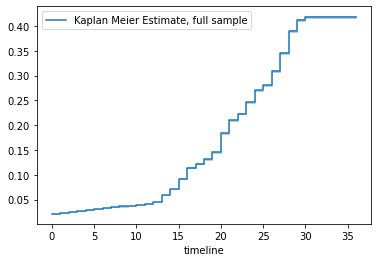

In [68]:
#Cumulative density plot
kmf.plot_cumulative_density()

# Section 3: Examining Variables

As we continue to examine the survival function, we may want to relate survival risk with features, or characteristics of our customers. In this example, we will look at diffences in survival risk for customers who have only a single service, vs. customers with multiple services. We can start by plotting a simple histogram for each category, looking at differences between churned and not-churned subsamples.

In [80]:
# Define variables by product category
df1 = data[data['Product Category']=='Accessories']
df2 = data[data['Product Category']=='Bikes']
df3 = data[data['Product Category']=='Clothing']

Text(0, 0.5, 'Survival probability')

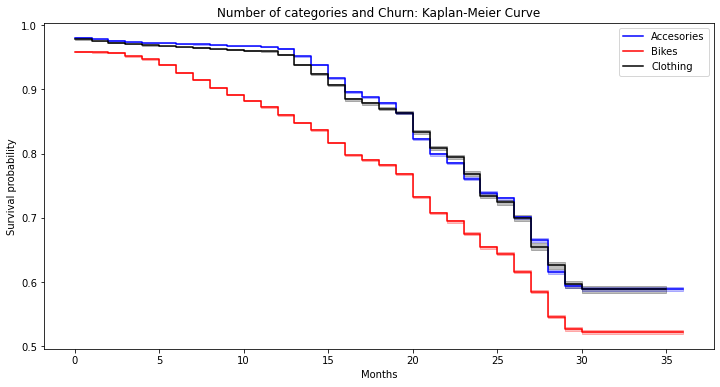

In [85]:
# We can see differences across these groups, let's examing Kaplan-Meier curves for various subsamples. 
# This involves fitting the Kaplan Meier estimator separately for each subsample. 

kmf.fit(df1['months_between'], df1['Customer_Churn'])
kmf.plot(label='Accesories', figsize=(12, 6),color = 'blue')
kmf.fit(df2['months_between'], df2['Customer_Churn'])
kmf.plot(label='Bikes',figsize=(12,6),color = 'red')
kmf.fit(df3['months_between'], df3['Customer_Churn'])
kmf.plot(label='Clothing', figsize=(12, 6),color='black')
plt.title('Number of categories and Churn: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

 # Section 4: Cox Proportional Hazards Model

Having looked at our data and related Kaplan-Meier curves, we can formalize the analysis by running survival regression. There are several available models here, documented in the Python [lifelines](https://lifelines.readthedocs.io/en/latest/) module. As we discussed in the course, the Cox model estimates a baseline hazard rate, and assumes features impact this hazard rate proportionally. While this is a strong assumption (and may not be true in general), the model still provides insight into the role of features and their importance impacting survival risk. Let's begin by setting data up for the Cox survival regression.

#### Cox Proportional Hazard Model assumptions include
1. Independence of survival times between distinct individuals in the sample
2. A multiplicative relationship between the predictors and the hazard
3. A constant hazard ratio over time. This assumption implies that, the hazard curves for the groups should be proportional and cannot cross. 

#### Hazard and Hazard Ratio
1. Hazard is defined as the slope of the survival curve. A measure of how rapidly subjects are dying.
2. The hazard ratio compares two treatments. If the hazard ratio is 2.0, then the rate of deaths in one treatment group is twice the rate in the other group.

In [73]:
# We begin by carrying out a little data modeling specificly for the model we are tring to create

dfu = data[['Product Category', 'Customer_Churn','months_between','Age','MaritalStatus','YearlyIncome']]
product_cat_dummies = pd.get_dummies(dfu['Product Category'],drop_first=True,dtype='int')

product_cat_dummies

dfu = dfu.drop('Product Category',axis=1)
dfd=pd.concat([dfu,product_cat_dummies],axis=1)

In [74]:
dfd.isna().sum()

Customer_Churn    0
months_between    0
Age               0
MaritalStatus     0
YearlyIncome      0
Bikes             0
Clothing          0
dtype: int64

In [75]:
dfd.head()

,Customer_Churn,months_between,Age,MaritalStatus,YearlyIncome,Bikes,Clothing
0,1,28,40,0,90000.0,0,0
1,1,28,42,0,90000.0,0,0
2,1,28,42,0,90000.0,0,0
3,1,28,42,0,90000.0,0,0
4,1,28,42,0,90000.0,0,0


Now, let's fit a Cox proportional hazard model using other variables.

In [76]:
cph = CoxPHFitter()
cph.fit(dfd, duration_col='months_between',event_col='Customer_Churn')
cph.print_summary(style='ascii')

<lifelines.CoxPHFitter: fitted with 5.24752e+06 total observations, 4.92318e+06 right-censored observations>
             duration col = 'months_between'
                event col = 'Customer_Churn'
      baseline estimation = breslow
   number of observations = 5.24752e+06
number of events observed = 324333
   partial log-likelihood = -4638962.27
         time fit was run = 2024-02-06 08:47:05 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Age           -0.02      0.98      0.00           -0.02           -0.02                0.98                0.98
MaritalStatus  0.28      1.32      0.00            0.27            0.29                1.31                1.33
YearlyIncome  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Bikes          0.65      1.92    

<AxesSubplot:xlabel='log(HR) (95% CI)'>

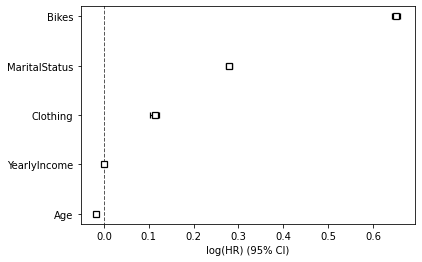

In [77]:
cph.plot()

<AxesSubplot:>

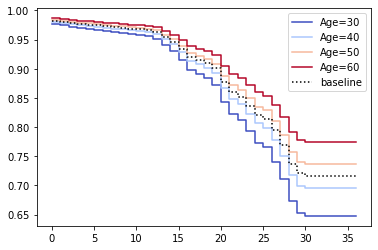

In [78]:
cph.plot_partial_effects_on_outcome(covariates = 'Age',
                                   values = [30,40,50,60],
                                   cmap = 'coolwarm')

# Model Summary

This Cox Proportional Hazards (CPH) model has been fitted to analyze the time until customers churn. Here's how to interpret the results:

1. **Baseline Estimation**:
   - Baseline estimation method used is Breslow.
   - This method is a common approach for handling ties in survival analysis.

2. **Number of Observations**:
   - Total observations in the dataset: 5,247,520.
   - Right-censored observations: 4,923,180.
   - Right-censored observations imply instances where the event (churn) did not occur within the observation period.

3. **Model Fit Statistics**:
   - Partial log-likelihood: -4,638,962.27.
   - The time the fit was run: February 6, 2024, at 08:47:05 UTC.

4. **Coefficients**:
   - Coefficients represent the effect of each covariate on the hazard rate (risk of churn).
   - "coef" is the coefficient estimate.
   - "exp(coef)" is the hazard ratio (exponential of the coefficient).
   - "se(coef)" is the standard error of the coefficient estimate.
   - "coef lower 95%" and "coef upper 95%" represent the lower and upper bounds of the 95% confidence interval for the coefficient estimate.
   - "exp(coef) lower 95%" and "exp(coef) upper 95%" are the corresponding bounds for the hazard ratio.

5. **Comparisons**:
   - "cmp to" indicates the comparison group for each covariate.
   - "z" is the z-score, a measure of how many standard deviations an element is from the mean.
   - "p" is the p-value associated with each coefficient.
   - "-log2(p)" provides the significance of each coefficient.

6. **Concordance**:
   - Concordance measures the predictive power of the model.
   - A concordance index of 0.68 indicates moderate predictive ability.

7. **Partial AIC**:
   - Partial AIC is the Akaike Information Criterion for model comparison.
   - Lower values indicate better model fit.

8. **Log-likelihood Ratio Test**:
   - A test comparing the fit of the current model to a null model.
   - The test statistic is 59,104.24 on 5 degrees of freedom (df).
   - "-log2(p)" indicates the significance of the test, which appears to be highly significant (inf).

**Interpretation**:
- Age, MaritalStatus, YearlyIncome, Bikes, and Clothing variables all have statistically significant effects on the hazard rate (churn risk).
- For example, as the number of Bikes increases, the hazard rate increases by a factor of approximately 1.92, holding other variables constant.
- Clothing seems to have a smaller effect compared to other variables, but it's still statistically significant.
- The model has a moderate predictive ability, as indicated by the Concordance index.

Overall, this model suggests that factors such as age, marital status, income, and purchasing behavior (Bikes and Clothing) significantly influence the time until customers churn. Further analysis and validation may be needed to refine the model and its predictions.

Certainly! Let's provide specific insights on each variable:

1. **Age**:
   - Coefficient (coef): -0.02
   - Hazard Ratio (exp(coef)): 0.98
   - Interpretation: For each one-unit increase in age, the hazard rate (risk of churn) decreases by approximately 2%. In other words, older customers are slightly less likely to churn compared to younger customers, holding other variables constant.

2. **MaritalStatus**:
   - Coefficient (coef): 0.28
   - Hazard Ratio (exp(coef)): 1.32
   - Interpretation: Customers who are single have a 32% higher hazard rate (risk of churn) compared to those in the reference category (assuming all else is constant).

3. **YearlyIncome**:
   - Coefficient (coef): -0.00
   - Hazard Ratio (exp(coef)): 1.00
   - Interpretation: There is no significant effect of yearly income on the hazard rate (risk of churn). The hazard ratio of 1.00 indicates that there is no change in the churn risk associated with changes in yearly income, holding other variables constant.

4. **Bikes**:
   - Coefficient (coef): 0.65
   - Hazard Ratio (exp(coef)): 1.92
   - Interpretation: For each additional unit of Bikes purchased, the hazard rate (risk of churn) increases by approximately 92%. This suggests that customers who purchase more bikes are almost twice as likely to churn compared to those who purchase fewer bikes, holding other variables constant.

5. **Clothing**:
   - Coefficient (coef): 0.11
   - Hazard Ratio (exp(coef)): 1.12
   - Interpretation: For each additional unit of Clothing purchased, the hazard rate (risk of churn) increases by approximately 12%. While statistically significant, the effect of Clothing purchases on churn risk is relatively small compared to other variables.

These insights provide a clear understanding of how each variable influences the likelihood of customer churn. Age, MaritalStatus, Bikes, and Clothing purchases all show significant effects on churn risk, while YearlyIncome does not seem to have a significant impact in this model.